In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('./sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


/dev/shm/marcin.kostur/data :: File exists


In [45]:
%%writefile data/sq.py
"""3D flow around obstacle in a channel.
"""

import numpy as np
from sailfish.subdomain import Subdomain3D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity, NTEquilibriumDensity, DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_base import ForceObject
from sailfish.lb_single import LBFluidSim
from sailfish.sym import S

Lz = 2*64
H = 180
L = int(6.25/4 * H)
D = int(0.05 * L)



class BoxSubdomain(Subdomain3D):
    bc = NTHalfBBWall
    max_v = 0.05

    def boundary_conditions(self, hx, hy, hz):
        walls = (hy == 0) | (hy == self.gy - 1)
        self.set_node(walls, self.bc)

        hhy = S.gy - self.bc.location
        self.set_node((hx == 0) & np.logical_not(walls),
                      NTEquilibriumVelocity(
                          DynamicValue(4.0 * self.max_v / H**2 * hhy * (H - hhy), 0.0, 0.0)))
        self.set_node((hx == self.gx - 1) & np.logical_not(walls),
                      NTEquilibriumDensity(1))
        l = L / 4

        # Full bounce-back. For N box nodes, effective size is N+1.
        if self.bc.location == 0.5:
            eff_D = D - 1
        # Half-way bounce-back. For N box nodes, effective size is N-2.
        else:
            eff_D = D + 2

        box = ((hx > l - eff_D / 2.0) & (hx <= l + eff_D / 2.0) &
               (hy > (H - eff_D) / 2.0) & (hy <= (H + eff_D) / 2.0))
        self.set_node(box, self.bc)

    def initial_conditions(self, sim, hx, hy, hz):
        sim.rho[:] = 1.0
        sim.vy[:] = 0.0
        sim.vz[:] = 0.0

        hhy = hy - self.bc.location
        sim.vx[:] = 4.0 * self.max_v / H**2 * hhy * (H - hhy)
        sim.vz[12,153:211,1:44] = 0.1

class BoxSimulation(LBFluidSim):
    subdomain = BoxSubdomain

    @classmethod
    def update_defaults(cls, defaults):
        defaults.update({
            'lat_nx': L,
            'lat_ny': (H + 2 if BoxSubdomain.bc.location == 0.5 else H),
            'lat_nz': Lz,
            'precision': 'single',
            'max_iters': 10000,
            'model':'mrt',
            'grid':'D3Q19',
            'periodic_z':True,
            'gpus':[1],
            'visc': 0.002})

    def __init__(self, *args, **kwargs):
        super(BoxSimulation, self).__init__(*args, **kwargs)

        margin = 5
        self.add_force_oject(ForceObject(
            (L / 4 - D / 2 - margin, (H - D) / 2 - margin,0),
            (L / 4 + D / 2 + margin, (H + D) / 2 + margin,Lz)))

        print '%d x %d | box: %d' % (L, H, D)
        print 'Re = %2.f' % (BoxSubdomain.max_v * D / self.config.visc)
        self.force = []
        
    def record_value(self, iteration, force, C_D, C_L):
        
        self.force.append([ iteration, force[0], force[1], force[2], C_D, C_L])

    prev_f = None
    every = 1000
    def after_step(self, runner):
        if self.iteration % self.every == 0:
            runner.update_force_objects()
            for fo in self.force_objects:
                runner.backend.from_buf(fo.gpu_force_buf)
                f = fo.force()

                # Compute drag and lift coefficients.
                C_D = (2.0 * f[0] / (D * BoxSubdomain.max_v**2))
                C_L = (2.0 * f[1] / (D * BoxSubdomain.max_v**2))
                self.record_value(runner._sim.iteration, f, C_D, C_L)

                if self.prev_f is None:
                    self.prev_f = np.array(f)
                else:
                    f = np.array(f)

                    # Terminate simulation when steady state has
                    # been reached.
                    diff = np.abs(f - self.prev_f) / np.abs(f)

                    if np.all(diff < 1e-6):
                        runner._quit_event.set()
                    self.prev_f = f
        if self.iteration == self.config.max_iters-1:
            np.savez(self.config.output+"_F",log=np.array(self.force))


ctrl = LBSimulationController(BoxSimulation)
ctrl.run()


Writing data/sq.py


In [72]:
casename = "sq_visc0.0020"
data = np.load('data/'+casename+'_F.npz')['log']

IOError: [Errno 2] No such file or directory: 'data/sq_visc0.0020_F.npz'

In [73]:
plt.plot(data[:,0],data[:,1])

TypeError: not all arguments converted during string formatting

%%sh
rm data/sq*npz
export PYTHONPATH=$PWD/sailfish/
python data/sq.py --max_iters=30000 --every=10000 --from=0000  --output=data/sq --output_format=npy  --subgrid='les-smagorinsky'

%%sh
export PYTHONPATH=$PWD/sailfish/
python data/sq.py --max_iters=100000 --every=1000 --from=80000 --output=data/sq --output_format=vtk 

In [74]:
import glob 
casefiles =sorted( glob.glob("data/"+casename+"*.*[0-9].npz") )
casefiles

['data/sq_visc0.0020.0.00000.npz',
 'data/sq_visc0.0020.0.01000.npz',
 'data/sq_visc0.0020.0.02000.npz',
 'data/sq_visc0.0020.0.03000.npz',
 'data/sq_visc0.0020.0.04000.npz',
 'data/sq_visc0.0020.0.05000.npz',
 'data/sq_visc0.0020.0.06000.npz',
 'data/sq_visc0.0020.0.07000.npz',
 'data/sq_visc0.0020.0.08000.npz',
 'data/sq_visc0.0020.0.09000.npz',
 'data/sq_visc0.0020.0.10000.npz',
 'data/sq_visc0.0020.0.11000.npz',
 'data/sq_visc0.0020.0.12000.npz',
 'data/sq_visc0.0020.0.13000.npz',
 'data/sq_visc0.0020.0.14000.npz',
 'data/sq_visc0.0020.0.15000.npz']

In [102]:
from sailfish.util import vorticity
import glob
from IPython.display import display

frames = []
bar = widgets.IntProgress(value=0,min=0,max=len(casefiles))
display(bar)
for fn in casefiles:
    data = np.load(fn)
    vx,vy,vz  = data['v']
    rho = data['rho'] 
    w = vorticity([vx, vy,vz])
    frames.append([vx, vy,vz,np.sum(w**2,axis=0),rho])
    bar.value+=1
print len(frames)
print frames[0][0].nbytes/1024**2

16
24


In [76]:
frames[0][0].shape,len(frames)

((128, 180, 281), 16)

In [77]:
print frames[0][0].nbytes/1024**2,"MB - total:",len(frames)*frames[0][0].nbytes/1024**2,"MB"

24 MB - total: 395 MB


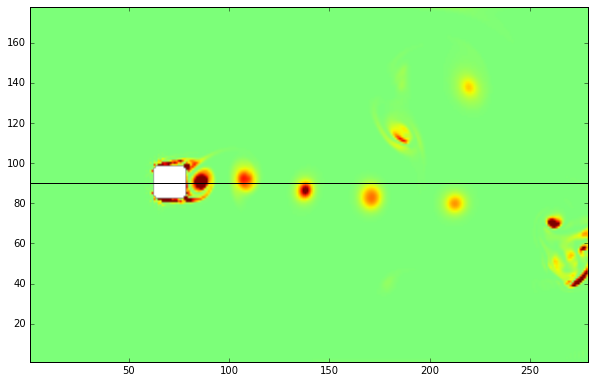

0.110855


In [101]:
from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
nz,ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          zi=widgets.IntSlider(min=0,max=(nz-1)),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'vz': 2,'rho':4,'vorticity':3},value=0)
         )
def g(ith,zi,figsize,sel):    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy,vz = frames[ith][:3]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel][zi,:,:],origin='top',vmin=-0.001,vmax=0.001)
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show() 
    print np.nanmax(vx)

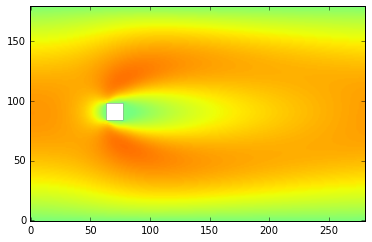

In [63]:
plt.imshow(frames[5][0][11,:,:],origin='top',vmin=-0.1,vmax=0.1)

In [15]:
np.nanmax( frames[5][0][112,:,:] ) 

0.090904586

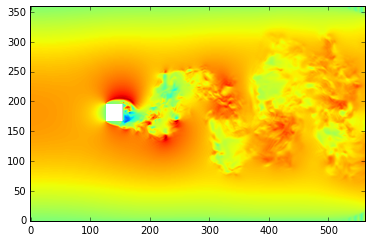

In [16]:
plt.imshow(frames[5][0][112,:,:],origin='top',vmin=-0.1,vmax=0.1)

In [ ]:
vx_smagframes[5][0][112,:,:]

In [19]:
from sailfish.util import vorticity

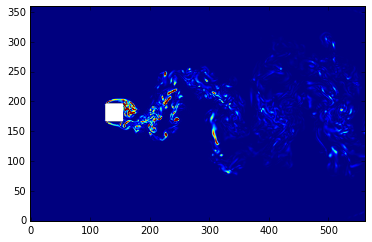

In [33]:
plt.imshow(frames[5][3][112,:,:],origin='top',vmin=0,vmax=0.001)

In [46]:
np.savez("data/vort",w=frames[5][3],v=data['v'])

In [42]:
src_data = np.load('data/vort.npz')
src_data.files
max(len(src_data[src_data.files[0]].shape), 0)


3

In [45]:
data['v'].shape

(3, 256, 360, 562)